# Crab Age Regression

**Context:** For a commercial crab farmer knowing the right age of the crab helps them decide if and when to harvest the crabs. Beyond a certain age, there is negligible growth in crab's physical characteristics and hence, it is important to time the harvesting to reduce cost and increase profit.

<br>

**Goal:** The dataset is used to estimate the age of the crab based on the physical attributes. 

<br>

**Feature Description:**
- Sex - Gender of the Crab (Male, Female and Indeterminate)
- Length - Length of the Crab (Feet)
- Diameter - Diameter of the Crab (Feet)
- Height - Height of the Crab (Feet)
- Weight - Weight of the Crab (Ounces)
- Shucked Weight - Weight without the shell (Ounces)
- Viscera Weight - It is weight that wraps around your abdominal organs deep inside body (Ounces)
- Shell Weight - Weight of the Shell (Ounces)
- Age - Age of the Crab (Months)

<br>

**Resources:**
- [Kaggle Challenge](https://www.kaggle.com/competitions/playground-series-s3e16/data?select=train.csv)
- [Original Dataset](https://www.kaggle.com/datasets/sidhus/crab-age-prediction)

In [1]:
# Import Standard Libraries
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import mlflow

from pathlib import Path
from colorama import Style, Fore

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, LearningCurveDisplay, \
                                    learning_curve, ShuffleSplit, GridSearchCV, \
                                    KFold

from sklearn.metrics import mean_squared_error, mean_absolute_error, \
                            mean_absolute_percentage_error, r2_score
from sklearn.ensemble import RandomForestRegressor

from scipy import stats

from xgboost import XGBRegressor

In [2]:
# Define Seaborn theme parameters
theme_parameters =  {
    'axes.spines.right': False,
    'axes.spines.top': False,
    'grid.alpha':0.3,
    'figure.figsize': (16, 6),
    'font.family': 'Andale Mono',
    'axes.titlesize': 24,
    'figure.facecolor': '#E5E8E8',
    'axes.facecolor': '#E5E8E8'
}

# Set the theme
sns.set_theme(style='whitegrid',
              palette=sns.color_palette('deep'), 
              rc=theme_parameters)

In [3]:
# Define Colors
black = Style.BRIGHT + Fore.BLACK
magenta = Style.BRIGHT + Fore.MAGENTA
red = Style.BRIGHT + Fore.RED
blue = Style.BRIGHT + Fore.BLUE
reset_colors = Style.RESET_ALL

# Read Data

In [4]:
# Switch flag for Kaggle Cloud
kaggle = False

# Switch flag for including original dataset
include_original_data = True

In [5]:
# Read training data
if kaggle:
    
    # Read data from Kaggle FS
    train_data = pd.read_csv('/kaggle/input/playground-series-s3e16/data.csv', index_col=0)
    original_data = pd.read_csv('', index_col=0)
    
else:
    
    # Define local data file paths
    train_data_file_path = Path(os.path.abspath('')).parents[1] / 'data' / 'S3E16' / 'crab_age_regression_train.csv'
    test_data_file_path = Path(os.path.abspath('')).parents[1] / 'data' / 'S3E16' / 'crab_age_regression_test.csv'
    original_data_file_path = Path(os.path.abspath('')).parents[1] / 'data' / 'S3E16' / 'crab_age_regression_original.csv'
   
    # Read data
    train_data = pd.read_csv(train_data_file_path, index_col=0)
    test_data = pd.read_csv(test_data_file_path, index_col=0)
    original_data = pd.read_csv(original_data_file_path)

# Exploratory Data Analysis (EDA)

In [10]:
# Define dictionary of data to plot
data_to_plot = {'Train': train_data, 
                'Test': test_data, 
                'Original': original_data}

## Shapes Information

In [11]:
# Print shapes information
print(f'{blue}Data Shapes:'
      f'{blue}\n- Train Data     -> {red}{train_data.shape}'
      f'{blue}\n- Original Data  -> {red}{original_data.shape}'
      f'{blue}\n- Test Data      -> {red}{test_data.shape}\n')

Data Shapes:
- Train Data     -> (74051, 9)
- Original Data  -> (3893, 9)
- Test Data      -> (49368, 8)



## Null Values Information

In [12]:
# Print null values information
print(f'{blue}Data Columns with Null Values:'
      f'{blue}\n- Train Data     -> {red}{train_data.isnull().any().sum()}'
      f'{blue}\n- Original Data  -> {red}{original_data.isnull().any().sum()}'
      f'{blue}\n- Test Data      -> {red}{test_data.isnull().any().sum()}\n')

Data Columns with Null Values:
- Train Data     -> 0
- Original Data  -> 0
- Test Data      -> 0



## Feature Distribution

### Numerical Feature Distribution

In [14]:
# Define raw numerical features
raw_numerical_features = ['Length', 
                          'Diameter', 
                          'Height', 
                          'Weight', 
                          'Shucked Weight', 
                          'Viscera Weight', 
                          'Shell Weight']

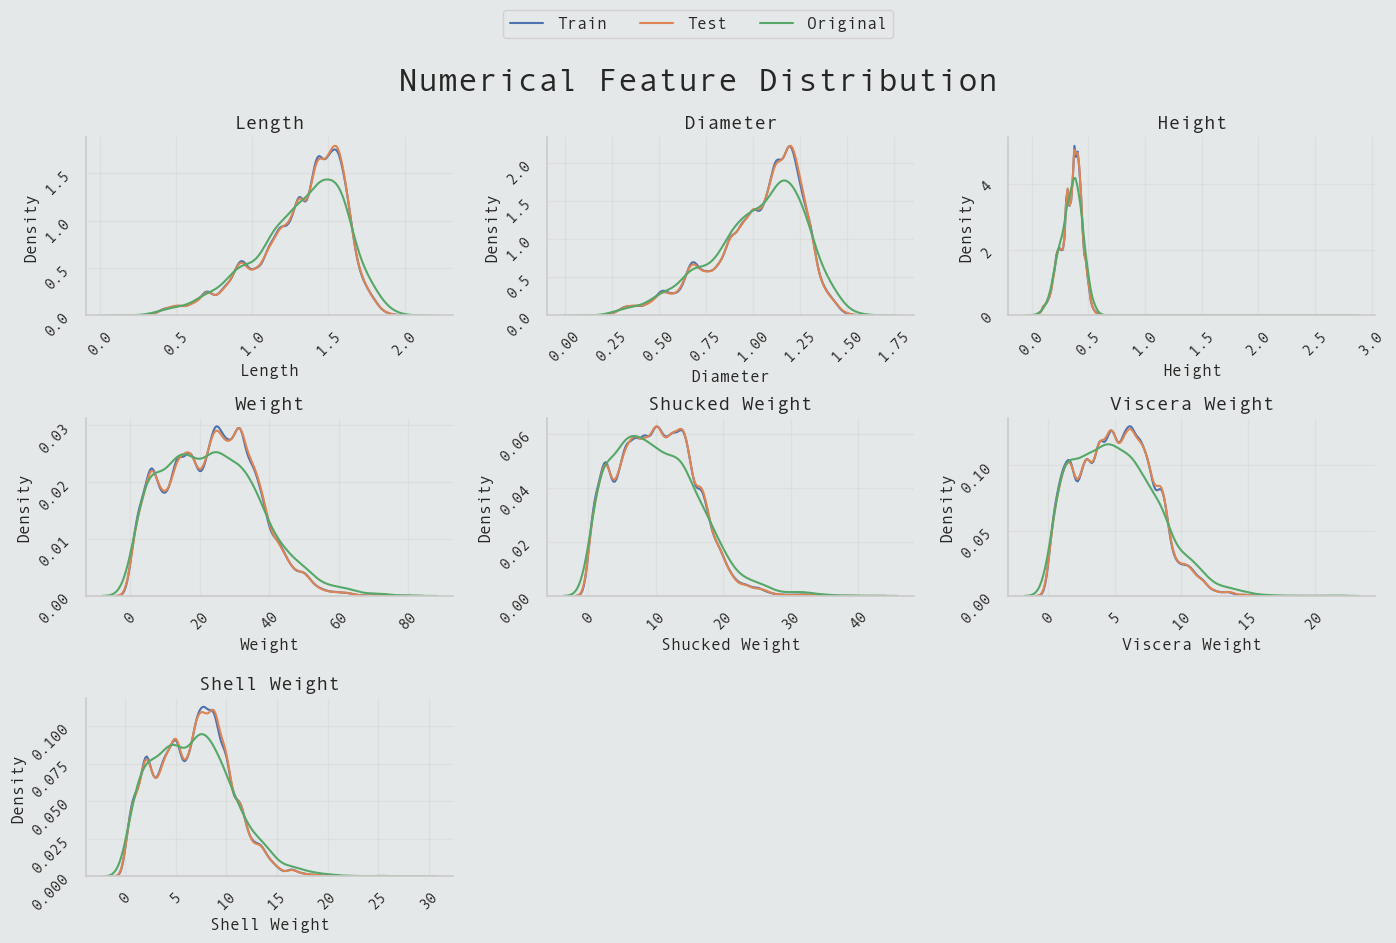

In [18]:
# Plot the KDE of each feature
figure, ax = plt.subplots(3, 3, figsize=(14, 9))
ax = ax.flatten()

# Fetch the data to plot
for index, column_name in enumerate(raw_numerical_features):
    
    # Plot data
    sns.kdeplot(data=train_data[column_name],
                label='Train',
                ax=ax[index])
    
    sns.kdeplot(data=test_data[column_name],
                label='Test',
                ax=ax[index])
    
    sns.kdeplot(data=original_data[column_name],
                label='Original',
                ax=ax[index])
    
    # Set subplot title
    ax[index].set_title(column_name, fontsize=14)
    
    # Set subplot tick rotation
    ax[index].tick_params(labelrotation=45)
    
    # Retrieve legend information
    handles = ax[index].get_legend_handles_labels()[0]
    labels = ax[index].get_legend_handles_labels()[1]
    ax[index].legend().remove()
    
# Remove the empty subplots
figure.delaxes(ax[-1])
figure.delaxes(ax[-2])
    
# Set the legend
figure.legend(handles, 
              labels, 
              loc='center', 
              bbox_to_anchor=(0.5, 1.03), 
              fontsize=12,
              ncol=3)

# Set figure Title
figure.suptitle('Numerical Feature Distribution',
                fontweight='bold',
                fontsize=24)

plt.tight_layout()

- Numerical features have different scales -> Apply Data Standardization
- Numerical features have right or left skewed distributions -> Apply Data Normalization

### Categorical Feature Distribution

#### Sex Distribution

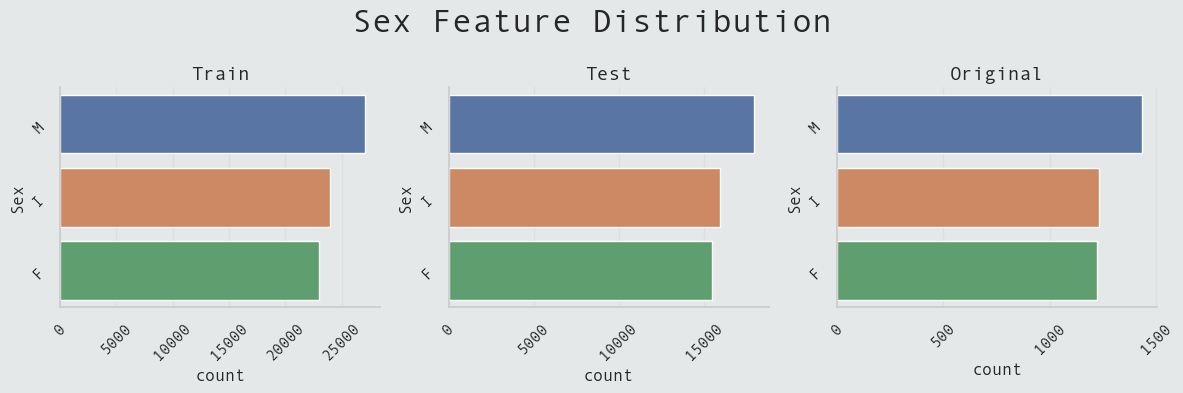

In [23]:
# Plot the countplot for the 'Author' feature
figure, ax = plt.subplots(3, 3, figsize=(12, 4))
ax = ax.flatten()

# Fetch the data to plot
for index, dataset_name in enumerate(data_to_plot.keys()):

    # Plot data
    sns.countplot(data=data_to_plot[dataset_name],
                  y='Sex',
                  label=dataset_name,
                  order=data_to_plot[dataset_name]['Sex'].value_counts().index,
                  ax=ax[index])

    # Set subplot tick rotation
    ax[index].tick_params(labelrotation=45)
    
    # Set subplot title
    ax[index].set_title(f'{dataset_name}', 
                        fontsize=14)

# Set figure Title
figure.suptitle('Sex Feature Distribution',
                fontweight='bold',
                fontsize=24)

plt.tight_layout()

- There are fairly equals samples from all the categories of `Sex`

## Numerical Feature Distribution per Sex

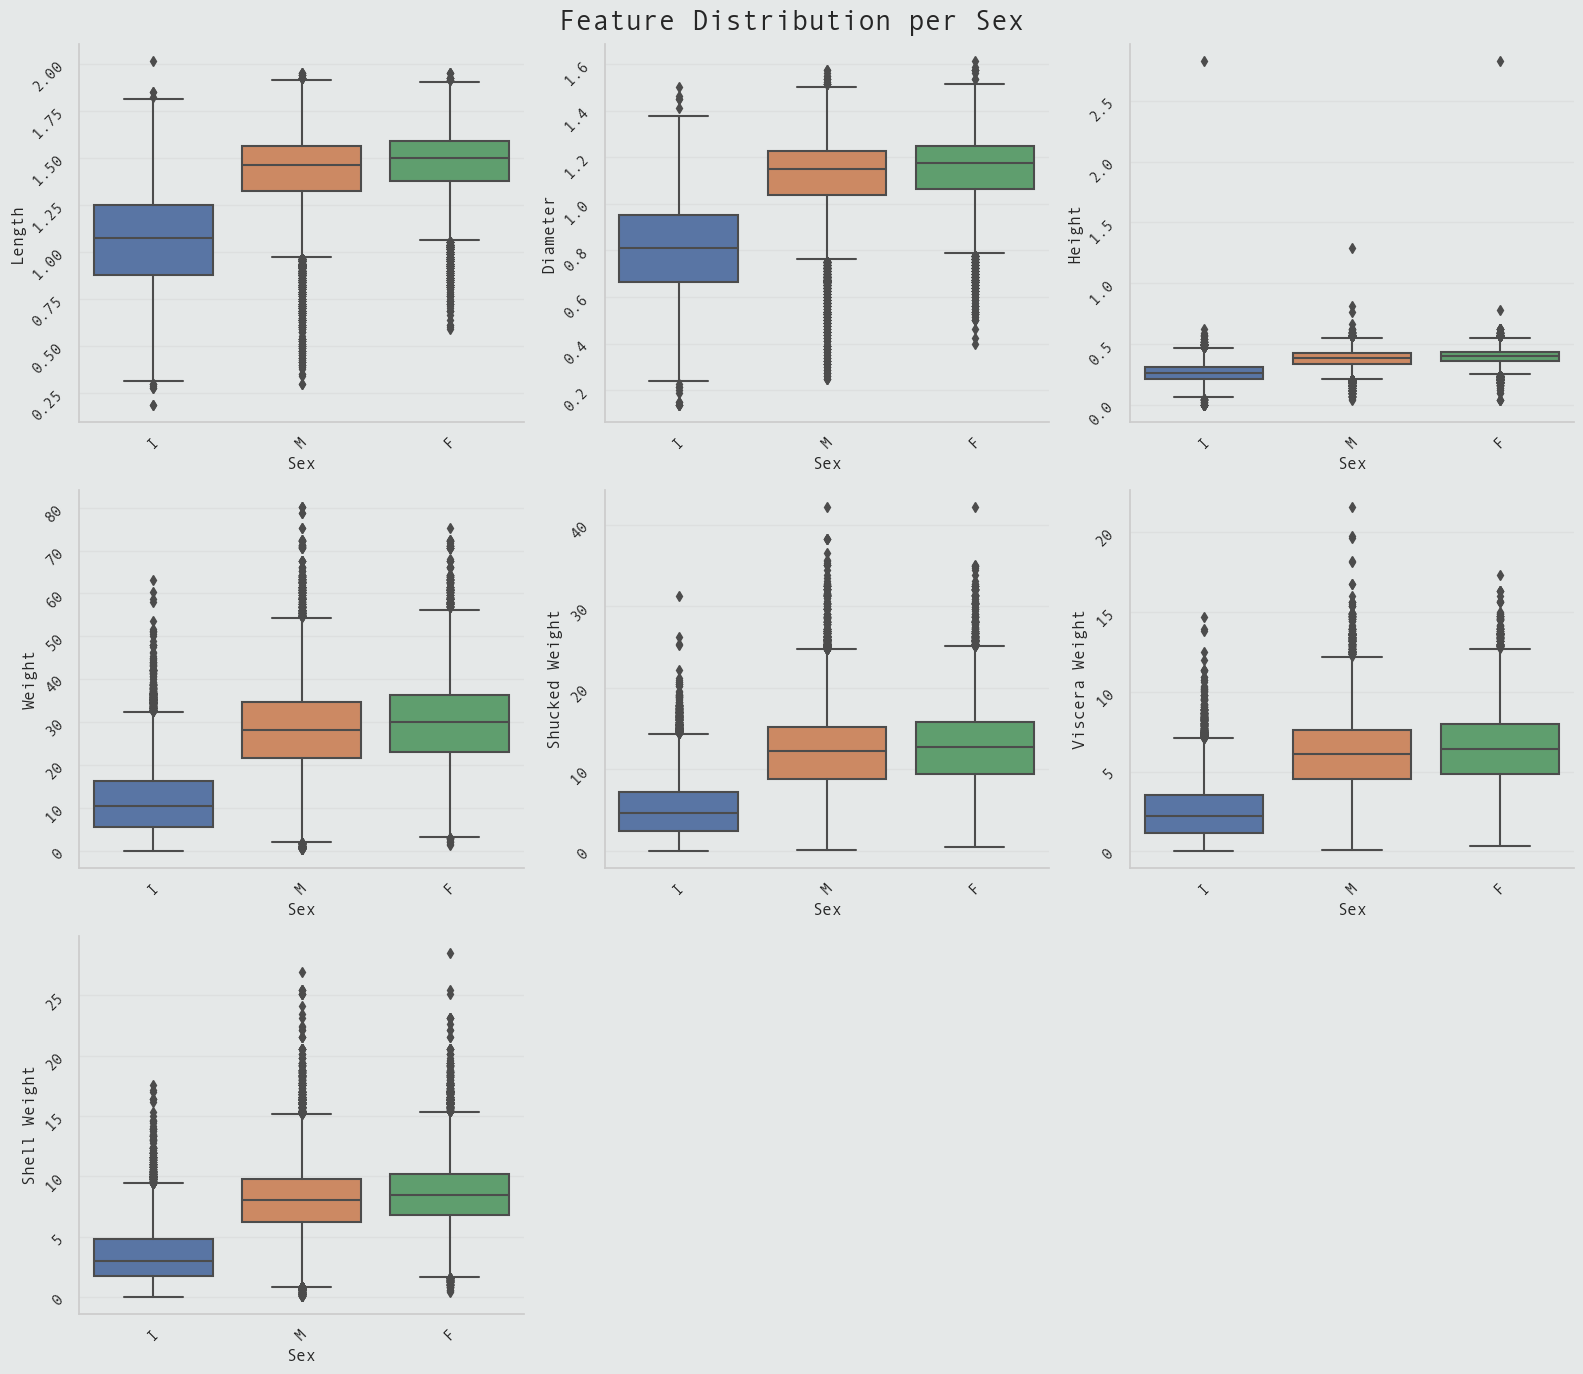

In [28]:
# Define figure and axes
figure, ax = plt.subplots(3, 3, figsize=(16, 14))
ax = ax.flatten()

# Fetch the data to plot
for index, column_name in enumerate(raw_numerical_features):
    
    # Plot data
    sns.boxplot(data=train_data,
                x='Sex',
                y=column_name,
                ax=ax[index])
    
    # Set subplot tick rotation
    ax[index].tick_params(labelrotation=45)
    
# Remove the empty subplots
figure.delaxes(ax[-1])
figure.delaxes(ax[-2])

# Set figure Title
figure.suptitle('Feature Distribution per Sex',
                fontweight='bold',
                fontsize=20)

plt.tight_layout()

- Numerical features vary quite heavily with respect to the `Sex` category. It is required to include `Sex` as a feature

## Label Distribution

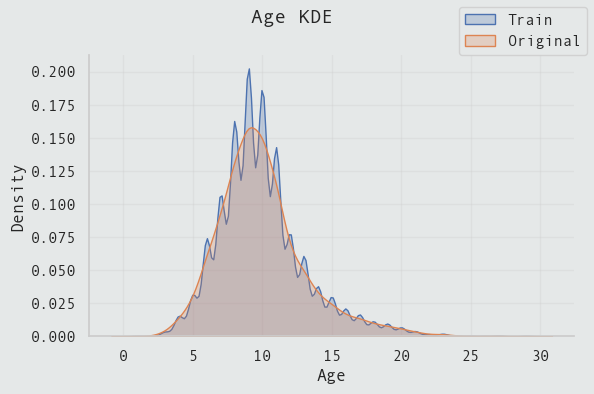

In [24]:
# Define figure and axes
figure, ax = plt.subplots(1, 1, figsize=(6, 4))

# Plot the KDE of label
sns.kdeplot(data=train_data['Age'], 
            fill=True,
            label='Train')

sns.kdeplot(data=original_data['Age'], 
            fill=True,
            label='Original')

# Set figure title
figure.suptitle('Age KDE', fontsize=14)

figure.legend()

plt.tight_layout()

- Train and Original data have the same label distribution

## Pearson Correlation

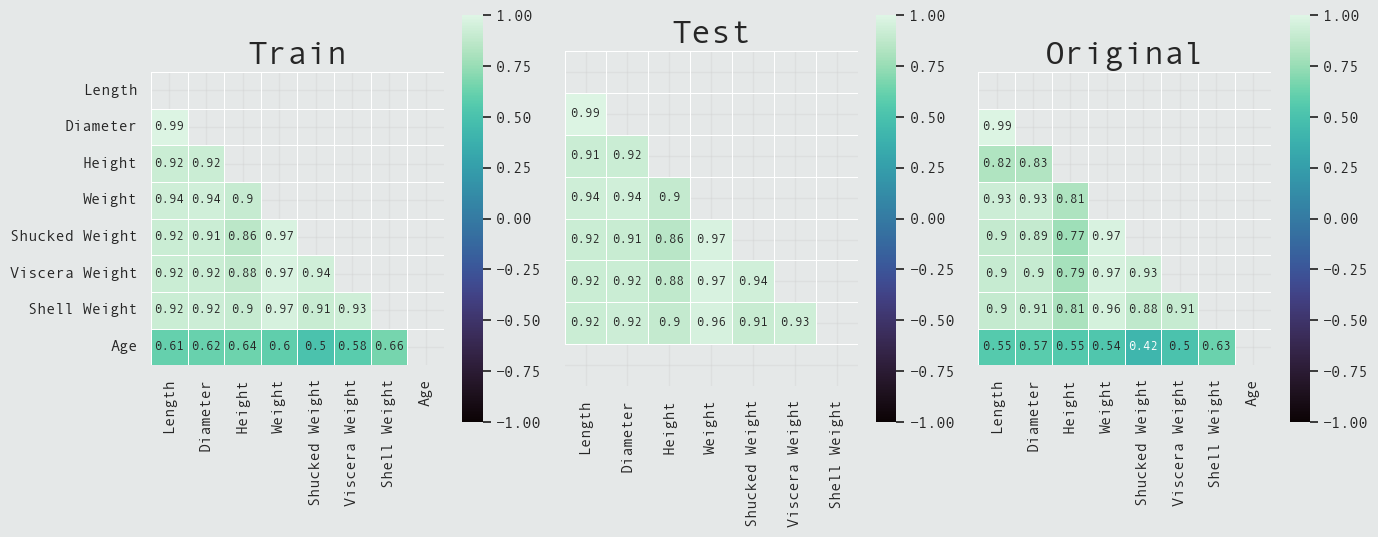

In [34]:
# Define figure and axis
figure, ax = plt.subplots(1, 3, figsize=(14, 6), sharey=True)
ax.flatten()

# Fetch the data to plot
for index, dataset_name in enumerate(data_to_plot.keys()):

    # Compute the correlation matrix
    correlation_matrix = data_to_plot[dataset_name].select_dtypes(include=np.number).corr()
    
    # Generate a mask for the upper triangle
    correlation_mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    # Plot the correlation matrix
    sns.heatmap(correlation_matrix, 
                mask=correlation_mask, 
                cmap='mako',
                vmax=1.0, 
                vmin=-1.0, 
                center=0, 
                square=True, 
                linewidths=.5, 
                annot=True,
                annot_kws={'fontsize': 9},
                cbar_kws={"shrink":.8, 'orientation':'vertical'}, 
                ax=ax[index])

    # Set title
    ax[index].set_title(f'{dataset_name}',
                        fontweight='bold')


plt.tight_layout()

- The features related to the weight are very correlated. It is better probably to keep just `Weight`
- Compute the `Volume` by multiplying `Length` x `Diameter` x `Height`

## Conclusions

- Quite a huge dataset. We can apply K-Fold and still have reasonable amount of data for each fold
- Apply Data Standardization
- Apply Data Normalization
- Include `Sex` as feature
- Include only `Weight` as a weight-based feature
- Compute `Volume` by multiplying `Length` x `Diameter` x `Height`

# Data Preparation

## Feature Engineering

In [6]:
class ComputeNumericalEngineeredFeatures(BaseEstimator, TransformerMixin):
    """
    Create a pre-defined set of engineered feature to the input DataFrame
    """
    
    def fit( self, X, y = None ):
        """
        This method is not required for this transformer
        """
        return self
    
    def transform(self, X):
    
        # Create a feature `D_e over pressure`
        X['Volume'] = X['Length'] * X['Diameter'] * X['Height']

        # Save column names
        self.feature_names = X.columns

        return X
    
    def get_feature_names_out(self, feature_names):
        """
        Retrieve the feature names
        """
        return [f'{col}' for col in self.feature_names]

## Data Pipeline

In [7]:
# Dictionary of data transformations to include
data_trasformations = {
    'numerical': {
        'feature_engineering': True,
        'standardization': True,
        'normalization': True
    },
    'categorical': {
        'one_hot_encoding': True,
    }
}

### Numerical Data Pipeline

In [8]:
class Log1pTransformer(BaseEstimator, TransformerMixin):
    """
    Implements a Numpy.log1p transformation for Scikit-Learn Pipeline
    """
    
    def fit(self, X, y=None):
        """
        This method is not required for this transformer
        """
        return self
    
    def transform(self, X):
        """
        Transform the data X with a Numpy.log1p transformation
        """
        # Apply np.log1p to the input array
        return np.log1p(X, where=True)
    
    def get_feature_names_out(self, feature_names):
        """
        Retrieve the feature names
        """
        return [f'{col}' for col in feature_names]

In [9]:
# Define numerical features
numerical_features = [
    'Length', 
    'Diameter', 
    'Height', 
    'Weight',
    'Shucked Weight',
    'Viscera Weight',
    'Shell Weight'
]

In [10]:
# Define the numerical data pipeline steps based on data_trasformations['numerical']
numerical_data_pipeline_steps = []

if data_trasformations['numerical']['feature_engineering']:
    numerical_data_pipeline_steps.append(('feature_engineering', ComputeNumericalEngineeredFeatures()))
if data_trasformations['numerical']['standardization']:
    numerical_data_pipeline_steps.append(('standardization', MinMaxScaler()))
if data_trasformations['numerical']['normalization']:
    numerical_data_pipeline_steps.append(('normalization', Log1pTransformer()))

### Categorical Data Pipeline

In [11]:
# Define categorical features
categorical_features = [
    'Sex'
]

In [12]:
# Define the categorical data pipeline steps based on data_trasformations['categorical']
categorical_data_pipeline_steps = []

if data_trasformations['categorical']['one_hot_encoding']:
    categorical_data_pipeline_steps.append(('one_hot_encoding', OneHotEncoder()))

### Bundle the Data Pipeline

In [13]:
# Define the data preparation transformations
data_preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', Pipeline(numerical_data_pipeline_steps), numerical_features),
        ('categorical', Pipeline(categorical_data_pipeline_steps), categorical_features),
    ])

## Features and Label Definition

In [14]:
# Define the features to include
features = numerical_features + categorical_features

# Define the labels to include
labels = ['Age']

# Train & Test Split

In [15]:
# Define X and y for the training set
if include_original_data:
    X = pd.concat([train_data[features], original_data[features]], axis=0).reset_index(drop=True)
    y = np.ravel(pd.concat([train_data[labels], original_data[labels]], axis=0).reset_index(drop=True))
else:
    X = train_data[features]
    y = np.ravel(train_data[labels])

In [16]:
# Split training data into train and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=108)

# Model Training

In [17]:
# Set MLflow Experiment
mlflow_experiment_name = 'Crab Age Regression'

# Create experiment or retrieve already existing experiment
try:
    mlflow_experiment_id = mlflow.create_experiment(name=mlflow_experiment_name)
except Exception as e:
    mlflow_experiment_id = mlflow.get_experiment_by_name(mlflow_experiment_name).experiment_id

In [18]:
# Define trained models
models = {}

# Define the used metrics
metrics = ['RMSE', 'MSE', 'MAE', 'MAPE', 'R2 Score']

# Initialize DataFrame of model performance
performance = pd.DataFrame(columns=metrics)

In [19]:
def train_model(model: any,
                pipeline_model_name: str,
                mlflow_run_name: str, 
                cv: any = None) -> any:
    """
    Train the passed 'model' instance
    
    Args:
        model: Any estimator instance with 'fit' and 'predict' functions
        pipeline_model_name: String model name for the Pipeline step
        mlflow_run_name: String Run name for the MLflow log
        cv: Any instance from sklearn.model_selection that implements a K-Folds Cross-Validator
    
    Returns:
        Fitted model
    """
    
    # Start MLflow Run
    with mlflow.start_run(experiment_id=mlflow_experiment_id, 
                          run_name=mlflow_run_name):
        
        print(f'{mlflow_run_name}\n')

        # Define the pipeline
        pipe = Pipeline([
            ('data_preprocessing', data_preprocessor),
            (pipeline_model_name, model)
        ])
        
        # Switch between Cross-Validation and Classic Training
        if not cv:
            
            # Train the pipeline
            pipe.fit(X_train, 
                     y_train)
            
            # Get predictions
            predictions = pipe.predict(X_test)

            # Compute metrics
            rmse = round(mean_squared_error(y_test, predictions) ** 0.5, 4)
            mse = round(mean_squared_error(y_test, predictions), 4)
            mae = round(mean_absolute_error(y_test, predictions), 4)
            mape = round(mean_absolute_percentage_error(y_test, predictions), 4)
            r2_score_value = round(r2_score(y_test, predictions), 4)
            
        else:
            
            # Initialise empty lists for metrics
            rmse_list, mse_list, mae_list, mape_list, r2_score_value_list = [], [], [], [], []
            
            # Fetch the folds
            for fold, (train_index, validation_index) in enumerate(cv.split(X, y)):
                                
                # Split the data
                X_train_fold = X.loc[train_index]
                X_validation_fold = X.loc[validation_index]
                y_train_fold = y[train_index]
                y_validation_fold = y[validation_index]
                
                # Train the pipeline
                pipe.fit(X_train_fold, 
                         y_train_fold)

                # Get predictions
                predictions_fold = pipe.predict(X_validation_fold)
                
                # Compute fold metrics
                rmse_fold = round(mean_squared_error(y_validation_fold, predictions_fold) ** 0.5, 4)
                mse_fold = round(mean_squared_error(y_validation_fold, predictions_fold), 4)
                mae_fold = round(mean_absolute_error(y_validation_fold, predictions_fold), 4)
                mape_fold = round(mean_absolute_percentage_error(y_validation_fold, predictions_fold), 4)
                r2_score_value_fold = round(r2_score(y_validation_fold, predictions_fold), 4)
                
                print('---- Fold {} ----'.format(fold))
                print('RMSE: {}'.format(rmse_fold))
                print('MSE: {}'.format(mse_fold))
                print('MAE: {}'.format(mae_fold))
                print('MAPE: {}'.format(mape_fold))
                print('R2 Score: {}'.format(r2_score_value_fold))
                print('\n')
                
                # Append mentrics to the corresponding list
                rmse_list.append(rmse_fold)
                mse_list.append(mse_fold)
                mae_list.append(mae_fold)
                mape_list.append(mape_fold)
                r2_score_value_list.append(r2_score_value_fold)
                
            # Compute metrics average
            rmse = round(np.mean(rmse_list), 4)
            mse = round(np.mean(mse_list), 4)
            mae = round(np.mean(mae_list), 4)
            mape = round(np.mean(mape_list), 4)
            r2_score_value = round(np.mean(r2_score_value_list), 4)

        print('RMSE: {}'.format(rmse))
        print('MSE: {}'.format(mse))
        print('MAE: {}'.format(mae))
        print('MAPE: {}'.format(mape))
        print('R2 Score: {}'.format(r2_score_value))
        print('\n')
        
        # Update 'performance' DataFrame
        performance.loc[mlflow_run_name] = [rmse, mse, mae, mape, r2_score_value]

        # Log model's evaluation metrics
        mlflow.log_metrics({'RMSE': rmse, 
                            'MSE': mse, 
                            'MAE': mae, 
                            'MAPE': mape, 
                            'R2': r2_score_value})

        # Log model's features
        mlflow.log_params({'Features': features, 
                           'Data Transformations': data_trasformations,
                           'Include Original Dataset': include_original_data})
        
        return pipe

## Linear Regression

In [20]:
%%time

# Define the model
model_lr = LinearRegression()

# Define the pipeline model step name and the MLflow Run Name
pipe_model_step_name_lr = 'linear_regression'
mlflow_run_name_lr = 'Linear Regression'

# Train the model
pipe_lr = train_model(model_lr, 
                      pipe_model_step_name_lr, 
                      mlflow_run_name_lr)

# Add the trained model to the list of models to analyse
models[mlflow_run_name_lr] = pipe_lr

Linear Regression

RMSE: 2.109
MSE: 4.4477
MAE: 1.4771
MAPE: 0.1435
R2 Score: 0.5632


CPU times: user 160 ms, sys: 109 ms, total: 269 ms
Wall time: 231 ms


## Random Forest Regressor

In [21]:
%%time

# Hyperparameters
hyperparameters_rfr = {
    'n_estimators': 500,
    'criterion': 'squared_error',
    'max_depth': 5,
    'min_samples_split': 8,
    'min_samples_leaf': 4
}

# Define the model
model_rfr = RandomForestRegressor(**hyperparameters_rfr)

# Define the pipeline model step name and the MLflow Run Name
pipe_model_step_name_rfr = 'random_forest_regressor'
mlflow_run_name_rfr = 'Random Forest Regressor'

# Train the model
pipe_rfr = train_model(model_rfr,
                       pipe_model_step_name_rfr,
                       mlflow_run_name_rfr)

# Add the trained model to the list of models to analyse
# models[mlflow_run_name_rfr] = pipe_rfr

Random Forest Regressor

RMSE: 2.1444
MSE: 4.5983
MAE: 1.4888
MAPE: 0.1433
R2 Score: 0.5484


CPU times: user 29.6 s, sys: 416 ms, total: 30 s
Wall time: 30.6 s


## XGBoost

In [22]:
%%time

# Hyperparameters
hyperparameters_xgb = {
    'n_estimators': 600,
    'objective': 'reg:squarederror',
    'max_depth': 6, 
    'min_child_weight': 10,
    'learning_rate': 0.01,
}

# Define the model
model_xgb = XGBRegressor(**hyperparameters_xgb)

# Define the pipeline model step name and the MLflow Run Name
pipe_model_step_name_xgb = 'xgboost'
mlflow_run_name_xgb = 'XGBoost'

# Train the model
pipe_xgb = train_model(model_xgb,
                       pipe_model_step_name_xgb,
                       mlflow_run_name_xgb)

# Add the trained model to the list of models to analyse
models[mlflow_run_name_xgb] = pipe_xgb

XGBoost

RMSE: 2.0462
MSE: 4.1867
MAE: 1.4074
MAPE: 0.1358
R2 Score: 0.5889


CPU times: user 59.9 s, sys: 439 ms, total: 1min
Wall time: 7.77 s


# Model Explanability

## Model Comparison

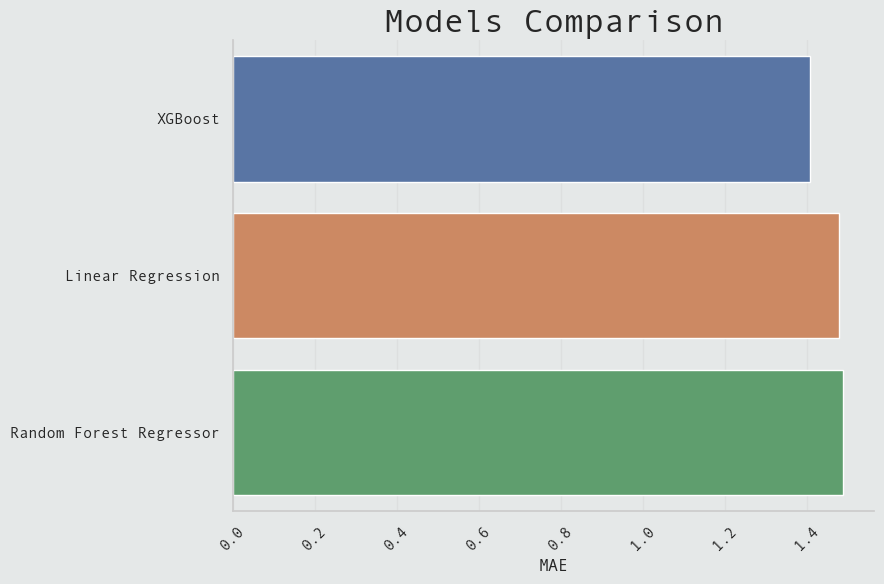

In [23]:
# Sort dataframe by the metric
performance.sort_values('MAE', inplace=True)

# Create figure
figure = plt.figure(tight_layout=True, figsize=(9, 6))

# Plot models' metrics
ax = sns.barplot(data=performance, 
                 x='MAE', 
                 y=performance.index.tolist())

# Set title
ax.set_title('Models Comparison', 
             fontsize=24)

# Set tick rotation
plt.xticks(rotation=45)

# Plot with tight layout
plt.tight_layout()

## Feature Importance

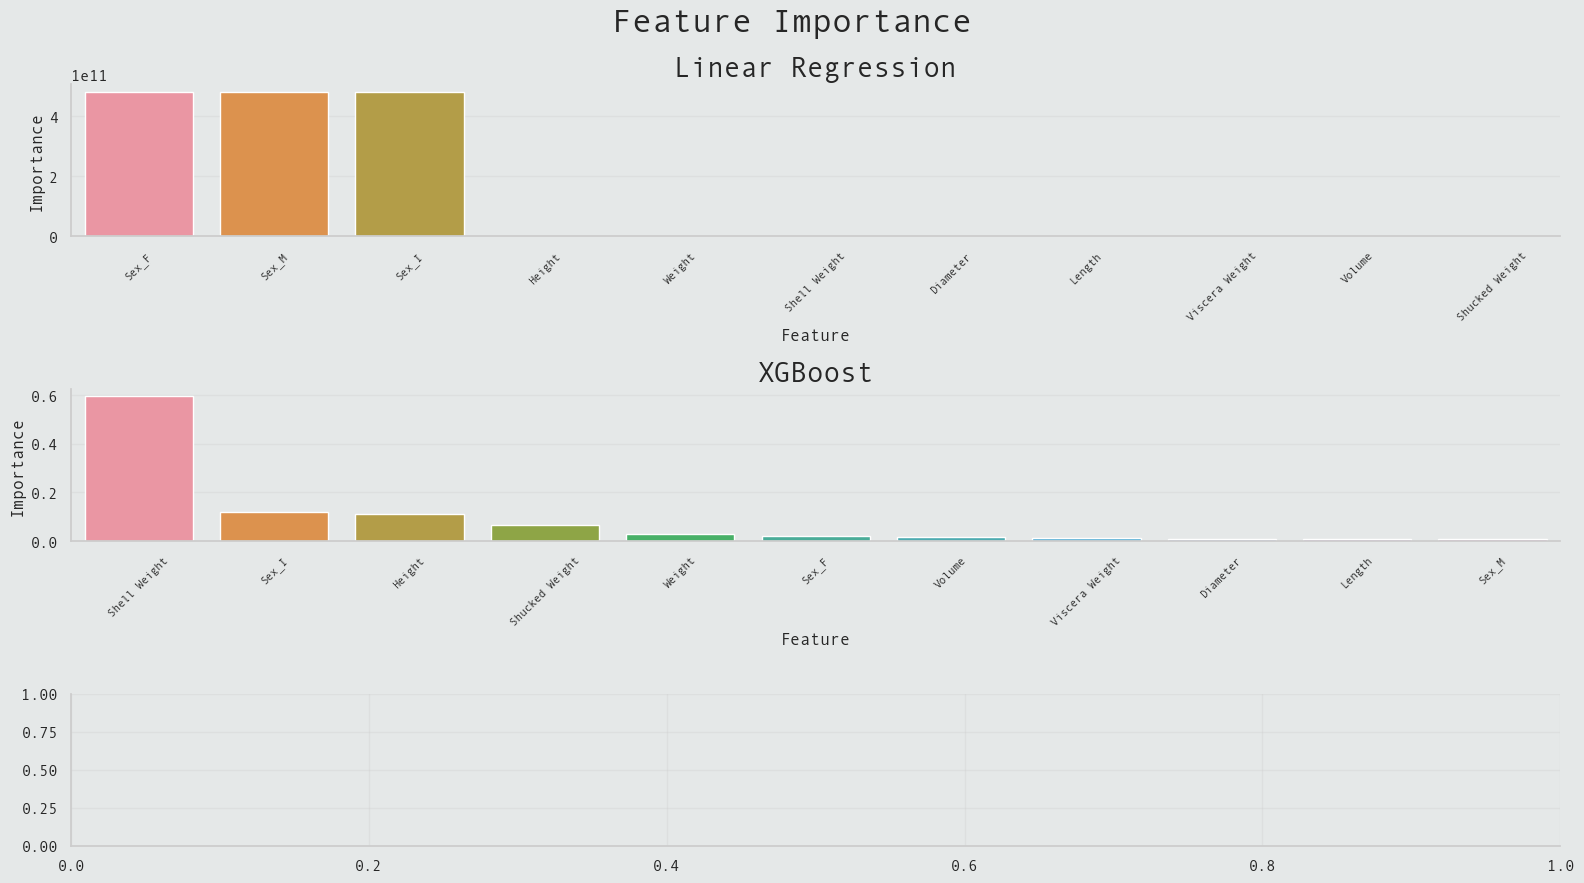

In [24]:
# Define figure and axes
figure, ax = plt.subplots(3, 1, figsize=(16, 9))
ax = ax.flatten()

# Fetch all the trained models
for index, model_name in enumerate(models.keys()):
    
    # Retrieve feature names
    feature_names = models[model_name].named_steps['data_preprocessing'].get_feature_names_out()
    
    # Refactor feature names to remove the ColumnTransformer prefix
    feature_names = [feature_name.split('__')[-1] for feature_name in feature_names]
    
    # Retrieve pipeline model's step name
    pipe_model_step_name = list(models[model_name].named_steps.keys())[-1]
    
    # Retrieve feature importances values
    try:
        # Tree-based models
        feautre_importance_values = models[model_name].named_steps[pipe_model_step_name].feature_importances_
    except:
        # Regression-based models
        feautre_importance_values = models[model_name].named_steps[pipe_model_step_name].coef_.reshape(-1,)
        
    
    
    # Compute the feature importance
    feature_importance = sorted(list(zip(feature_names,
                                         feautre_importance_values)),
                                key=lambda x: x[1], reverse=True)

    # Transform it into a DataFrame
    feature_importance_df = pd.DataFrame(feature_importance,
                                         columns= ['Feature', 'Importance'])    
    
    # Plot the feature importance
    sns.barplot(data=feature_importance_df,
               x='Feature',
               y='Importance', 
               ax=ax[index])

    # Set title
    ax[index].set_title(model_name, 
                 fontsize=20)

    # Refine x labels
    ax[index].set_xticklabels(feature_importance_df['Feature'],
                              fontsize=8,
                              rotation=45)

# Define figure title
figure.suptitle('Feature Importance',
                fontweight='bold',
                fontsize=24)

# Plot with tight layout
plt.tight_layout()

## Learning Curves

In [25]:
# Define Learning Curves Display parameters
learning_curves_display_paramters = {
    'X': X,
    'y': y,
    'cv': ShuffleSplit(n_splits=3, test_size=0.3, random_state=108),
    'train_sizes': np.linspace(0.1, 1.0, 8),
    'scoring': 'neg_root_mean_squared_error',
    'negate_score': True,
    'score_name': 'RMSE',
    'score_type': 'both',
    'verbose': 0,
    'line_kw': {'marker': 'o'},
    'std_display_style': 'fill_between',
}

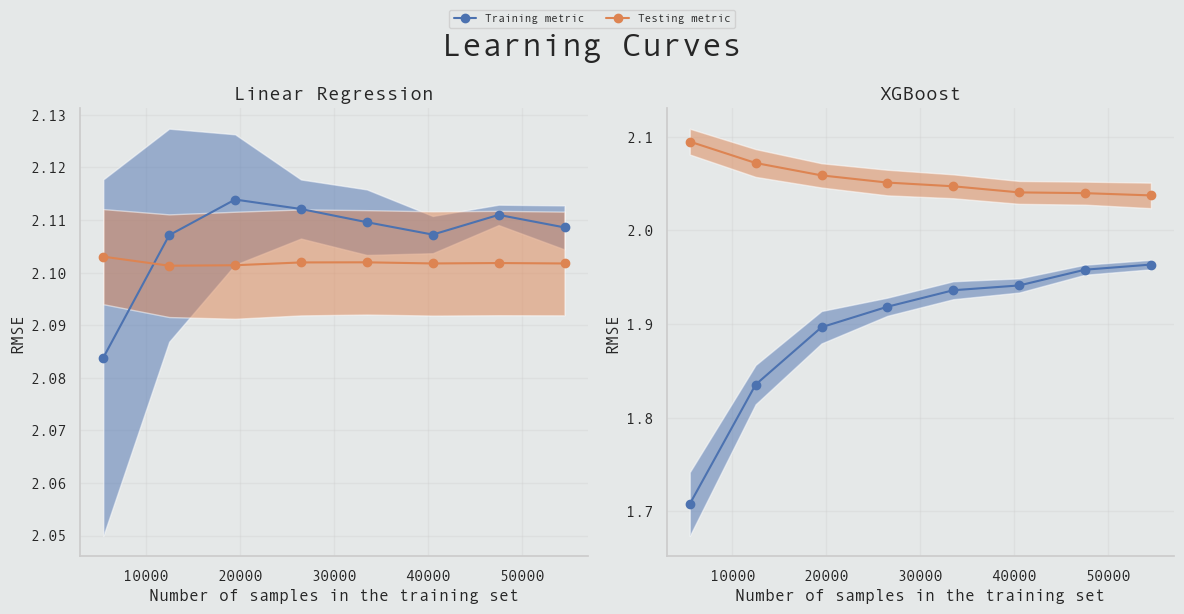

In [26]:
# Define figure and axes
figure, ax = plt.subplots(1, 2, figsize=(12, 6))
ax = ax.flatten()

# Fetch all the trained models
for index, model_name in enumerate(models.keys()):

    # Plot the Learning Curve
    LearningCurveDisplay.from_estimator(models[model_name], 
                                        **learning_curves_display_paramters,
                                        ax=ax[index])
    
    # Retrieve legend information
    handles = ax[index].get_legend_handles_labels()[0]
    labels = ax[index].get_legend_handles_labels()[1]
    ax[index].legend().remove()
    
    # Set the title
    ax[index].set_title(model_name, fontsize=14)
    
# Set the legend
figure.legend(handles, 
              labels, 
              loc='upper center', 
              bbox_to_anchor=(0.5, 1.03), 
              fontsize=8,
              ncol=2)

# Define figure title
figure.suptitle('Learning Curves',
                fontweight='bold',
                fontsize=24)
    
# Plot with tight layout
plt.tight_layout()

## Residuals

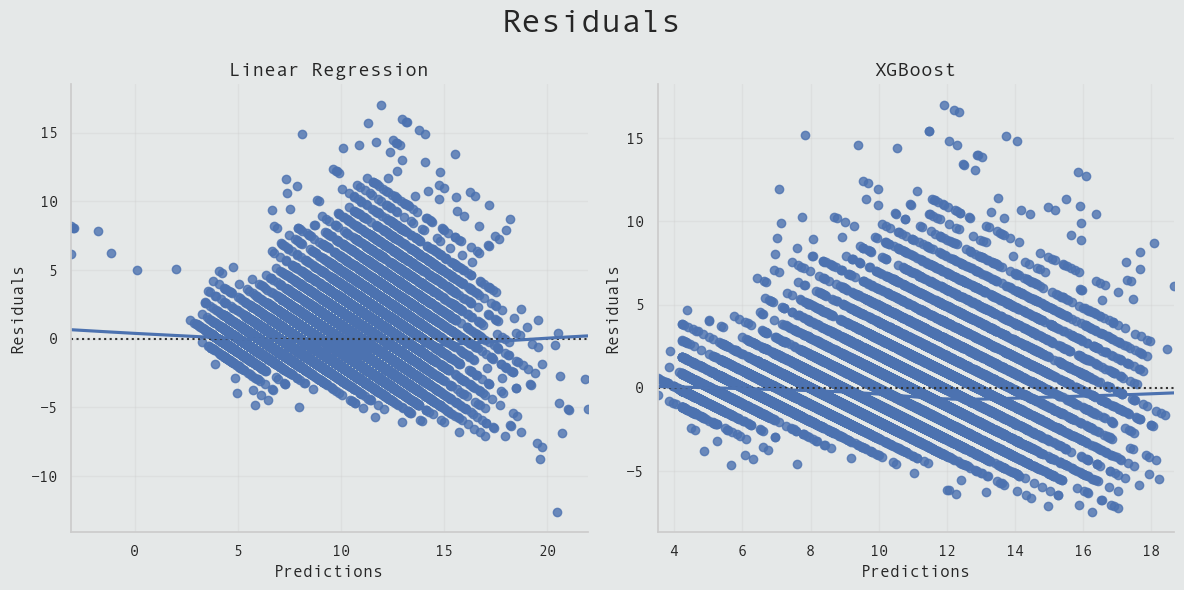

In [27]:
# Define figure and axes
figure, ax = plt.subplots(1, 2, figsize=(12, 6))
ax = ax.flatten()

# Fetch all the trained models
for index, model_name in enumerate(models.keys()):
    
    # Compute the predictions for the test set
    predictions = models[model_name].predict(X_test)
    
    # Reshape predictions
    predictions = predictions.reshape(-1,)
    
    # Compute the residuals
    residuals = y_test - predictions
    
    # Create the Pandas DataFrame
    residuals_df = pd.DataFrame({'Residuals': residuals, 
                                 'Predictions': predictions})
    
    # Plot the residuals
    sns.residplot(x='Predictions', 
                  y='Residuals',
                  data=residuals_df, 
                  ax=ax[index],
                  lowess=True)

    # Set the title
    ax[index].set_title(model_name, fontsize=14)

# Define figure title
figure.suptitle('Residuals',
                fontweight='bold',
                fontsize=24)

# Plot with tight layout
plt.tight_layout()

## Q-Q Plots

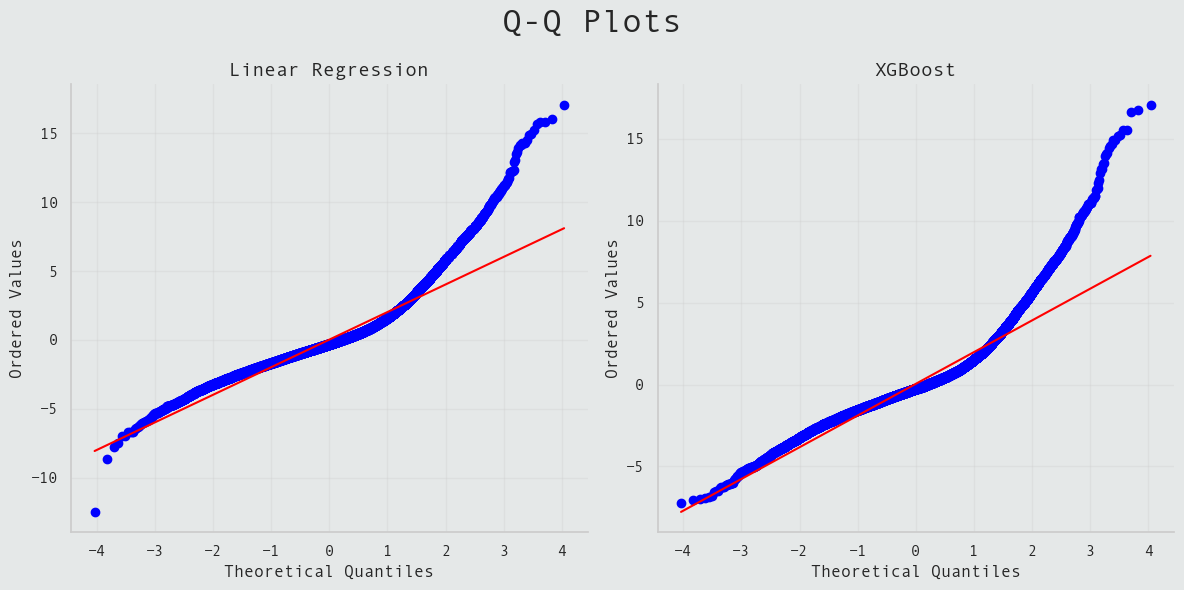

In [28]:
# Define figure and axes
figure, ax = plt.subplots(1, 2, figsize=(12, 6))
ax = ax.flatten()

# Fetch all the trained models
for index, model_name in enumerate(models.keys()):
    
    # Compute the predictions for the test set
    predictions = models[model_name].predict(X_test)
    
    # Reshape predictions
    predictions = predictions.reshape(-1,)
    
    # Compute the residuals
    residuals = y_test - predictions
    
    # Generate a QQ plot
    stats.probplot(residuals, 
                   plot=ax[index])
    
    ax[index].set_xlabel('Theoretical Quantiles')

    # Set the title
    ax[index].set_title(model_name, fontsize=14)
    
    
figure.suptitle('Q-Q Plots',
                fontweight='bold',
                fontsize=24)

plt.tight_layout()